In [8]:
import pandas as pd
import matplotlib.pyplot as plt
#from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser
import os

In [61]:
from ast import literal_eval
files = [r'C:\Users\huda\Downloads\results_ortools.txt', r'C:\Users\huda\Downloads\results_cplex_cp.txt', r'C:\Users\huda\Downloads\results_gurobi.txt', r'C:\Users\huda\Downloads\results_hexaly_rewritten.txt', r'C:\Users\huda\Downloads\results_cplex_lp_rewritten.txt']
all_data = dict()
for file in files:
    file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    df = pd.DataFrame(file_content)
    if file.split('\\')[-1][:-4] == 'results_hexaly_rewritten':
        all_data['results_hexaly'] = df
    elif file.split('\\')[-1][:-4] == 'results_cplex_lp_rewritten':
         all_data['results_cplex_lp'] = df
    else:
        all_data[file.split('\\')[-1][:-4]] = df
del df
del file_content

In [64]:
for key in all_data.keys():
    df = all_data[key]
    df = df[~df['name'].str.startswith('Error')]
    df = df[df['fitness_value'] != float('inf')]
    df.resource_history = df.resource_history.apply(literal_eval)
    all_data[key] = df

KeyboardInterrupt: 

In [10]:
def get_comparison(data, instance, column, max = False):
    if max:
        best = -float('inf')
    else:
        best = float('inf')
    for key in data.keys():
        optimizer = data[key]
        if instance in optimizer.name.values:
            fitness = optimizer.loc[optimizer['name'] == instance][column].tolist()[0]
            if max and fitness > best:
                best = fitness
            elif not max and fitness < best:
                best = fitness
    return best

def calculate_value(fitness, best):
    return ((fitness - best) / best)

def get_cdf_comparison_vector(data : dict, column, max, instances):
    results = []
    for _ in data:
        results.append([])
    for instance in instances:
        best = get_comparison(data, instance, column, max)
        i = 0
        for key in data.keys():
            if not instance in data[key].name.values:
                results[i].append(-float('inf') if max else float('inf'))
            else:
                results[i].append(calculate_value(data[key].loc[data[key]['name'] == instance][column], best).item())
            i += 1
    for result in results:
        if max:
            result.sort(reverse=True)
        else:
            result.sort()
    return results

In [35]:
def ecdf_inf(data, column, max : bool = False, n_instances : int = 402, labels : list[str] = [], instances : list[str] = []):
    vectors = get_cdf_comparison_vector(data, column, max, instances)
    plot_vectors = []
    for vector in vectors:
        plot_vectors.append([[0.0],[0.0]])
        i = 1
        while i < len(vector):
            if vector[i] == float('inf'):
                break
            if vector[i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0].append(vector[i-1])
            plot_vectors[-1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(vectors)):
        plt.plot(plot_vectors[i][0], plot_vectors[i][1], label=[labels[i]])
    if column == 'fitness_value':
        plt.xlim(-0.1, 1.0)
        
    plt.legend()
    plt.title(column)
    plt.show()


In [36]:
instances = os.listdir(r'C:\Users\huda\Downloads\benchmarks_with_workers\benchmarks_with_workers')

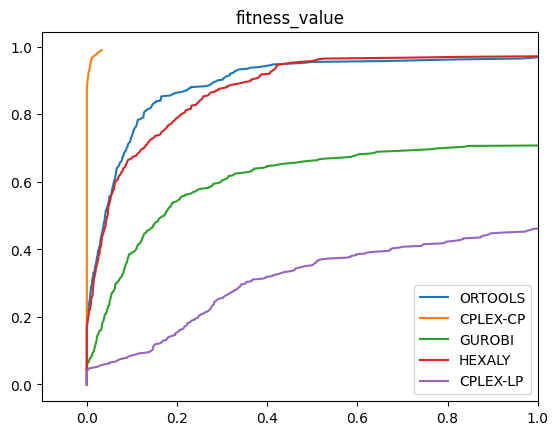

In [37]:
ecdf_inf(all_data, 'fitness_value', labels=['ORTOOLS', 'CPLEX-CP', 'GUROBI', 'HEXALY', 'CPLEX-LP'], instances=instances)

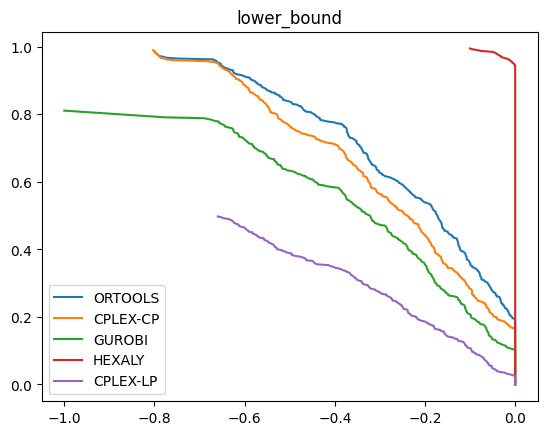

In [38]:
ecdf_inf(all_data, 'lower_bound', max=True, labels=['ORTOOLS', 'CPLEX-CP', 'GUROBI', 'HEXALY', 'CPLEX-LP'], instances=instances) 

In [42]:
all_data['results_hexaly']

,name,optimization_status,fitness_value,lower_bound,runtime,result_vector1,result_vector2,result_vector3,peak_cpu,peak_ram,resource_history,best_result_history
0,0_BehnkeGeiger_10_workers.fjs,-1,159,105,1200,"[72, 98, 118, 133, 149, 62, 78, 88, 99, 118, 1...","[2, 5, 14, 5, 17, 3, 5, 5, 6, 17, 3, 16, 16, 6...","[11, 25, 11, 16, 19, 22, 10, 3, 28, 14, 4, 11,...",0.0,0.0,"[(0, 0), (34.4, 24.1), (48.3, 24.0), (41.9, 24...","[(0, inf, -inf), (1, 2926, 75), (2, 1262, 75),..."
1,0_BehnkeGeiger_11_workers.fjs,-1,483,200,1200,"[134, 191, 214, 240, 346, 87, 116, 130, 214, 3...","[2, 16, 8, 13, 20, 4, 13, 16, 15, 18, 1, 5, 9,...","[2, 18, 21, 17, 10, 14, 22, 20, 17, 22, 9, 28,...",0.0,0.0,"[(0, 0), (39.3, 24.2), (49.9, 24.2), (48.7, 24...","[(0, inf, -inf), (1, 7357, 72), (2, 7357, 72),..."
2,0_BehnkeGeiger_12_workers.fjs,-1,518,194,1200,"[234, 253, 298, 353, 363, 147, 194, 229, 289, ...","[1, 8, 9, 12, 17, 3, 11, 7, 10, 20, 1, 6, 7, 1...","[16, 25, 22, 27, 3, 7, 18, 1, 13, 26, 20, 29, ...",0.0,0.0,"[(0, 0), (37.4, 24.1), (50.3, 24.1), (48.9, 24...","[(0, inf, -inf), (1, 7351, 71), (2, 7351, 71),..."
3,0_BehnkeGeiger_13_workers.fjs,-1,572,203,1200,"[66, 103, 115, 305, 316, 54, 74, 104, 253, 310...","[3, 16, 5, 9, 20, 2, 7, 13, 15, 17, 3, 9, 9, 1...","[11, 27, 2, 27, 24, 30, 10, 23, 4, 15, 5, 3, 1...",0.0,0.0,"[(0, 0), (37.5, 24.2), (50.3, 24.2), (36.4, 24...","[(0, inf, -inf), (1, 0, 76), (2, 7392, 76), (3..."
4,0_BehnkeGeiger_14_workers.fjs,-1,491,199,1200,"[357, 384, 408, 431, 453, 286, 344, 361, 407, ...","[1, 9, 10, 15, 18, 1, 15, 8, 13, 18, 1, 6, 13,...","[23, 28, 29, 18, 22, 11, 28, 21, 22, 12, 12, 1...",0.0,0.0,"[(0, 0), (37.2, 24.1), (50.6, 24.1), (45.1, 24...","[(0, inf, -inf), (1, 7329, 82), (2, 7329, 82),..."
...,...,...,...,...,...,...,...,...,...,...,...,...
397,6_Fattahi_5_workers.fjs,-1,117,106,1200,"[0, 55, 20, 93, 0, 55]","[2, 1, 1, 2, 1, 2]","[3, 3, 2, 2, 2, 2]",0.0,0.0,"[(0, 0), (29.6, 25.1), (62.4, 24.9), (56.3, 24...","[(0, inf, -inf), (1, 117, 96), (2, 117, 106), ..."
398,6_Fattahi_6_workers.fjs,1,305,305,0,"[0, 48, 87, 18, 87, 231, 0, 55, 220]","[1, 1, 2, 1, 1, 3, 2, 3, 2]","[4, 4, 1, 2, 4, 4, 3, 2, 2]",0.0,0.0,"[(0, 0)]","[(0, inf, -inf)]"
399,6_Fattahi_7_workers.fjs,1,386,386,0,"[0, 113, 240, 0, 162, 264, 0, 79, 156]","[2, 2, 4, 3, 3, 5, 1, 4, 5]","[2, 1, 2, 5, 6, 7, 1, 7, 7]",0.0,0.0,"[(0, 0)]","[(0, inf, -inf)]"
400,6_Fattahi_8_workers.fjs,-1,240,215,1200,"[27, 53, 80, 0, 27, 79, 27, 80, 148]","[2, 2, 4, 1, 4, 3, 1, 2, 3]","[3, 2, 4, 3, 4, 6, 1, 3, 2]",0.0,0.0,"[(0, 0), (31.5, 25.0), (67.5, 24.7), (57.5, 24...","[(0, inf, -inf), (1, 248, 210), (2, 240, 215),..."


In [57]:
def find_time_vectors(data, distance, column, overall : bool = True):
    if column == 'fitness_value':
        target = min([min(d['resource_history'][1][1]) for d in data])
    else: # lower_bound
        target = max([max(d['resource_history'][2][1]) for d in data])
    target *= (1.0 - distance) if column == 'fitness_value' else (1.0 + distance)
    results = []
    for d in data:
        for t in d['best_result_history']:
            if column == 'fitness_value':
                if not overall:
                    target = d['fitness_value'] * (1.0 - distance)
                if t[1] <= target:
                    results.append(t[0])
                    break
            else:
                if not overall:
                    target = d['lower_bound'] * (1.0 + distance)
                if t[2] >= target:
                    results.append(t[0])
                    break
    return results
        

In [49]:
in_data = [all_data[key] for key in all_data.keys()]

In [54]:
len(in_data)

5

In [58]:
find_time_vectors(in_data, 0.1, 'fitness_value')

TypeError: 'float' object is not iterable